## PS 4
## Olivia Natan


In [1]:
import numpy as np
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import numpy.linalg as lin
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

### Setup

In this problem, we have data on the distribution of households across income brackets, and we are going to do some moment matching via GMM

##### Data setup:

The data are stored as tab-delimited data in 42 bins in 'usincmoms.txt', the first number is the bin midpoint, the second is the percent of the population (indivs vs hhs?) in the bin. 

First, we import the data

In [2]:
df = pd.read_csv('usincmoms.txt',delim_whitespace=True,header=None,names=['Percent','Midpoint'])
df.head()

,Percent,Midpoint
0,0.035190,2500
1,0.041062,7500
2,0.058859,12500
3,0.056836,17500
4,0.058595,22500


Next, we add endpoints to the ranges:

In [3]:
df['bottom'],df['top'] = None, None
df.loc[0,'bottom']= 0
df.loc[0,'top'] = df.loc[0,'Midpoint'] + (df.loc[0,'Midpoint']-df.loc[0,'bottom'])
for j in df.index[1:]:
    df.loc[j,'bottom'] = df.loc[j-1,'top']
    df.loc[j,'top'] =df.loc[j,'Midpoint'] + (df.loc[j,'Midpoint']-df.loc[j,'bottom'])
df['range_text'] = df['bottom'].astype(str) + " to "+(df['top']-1).astype(str)
df['midpoint_000s'] = df['Midpoint']/1000
df['binwidth'] = (df.top - df.bottom)/1000
df['percent_bar'] = df['Percent']
df.loc[40,'percent_bar'] = df.loc[40,'percent_bar']/10
df.loc[41,'percent_bar'] = df.loc[41,'percent_bar']/20
df.tail()

,Percent,Midpoint,bottom,top,range_text,midpoint_000s,binwidth,percent_bar
37,0.002998,187500,185000,190000,185000 to 189999,187.5,5,0.002998
38,0.003138,192500,190000,195000,190000 to 194999,192.5,5,0.003138
39,0.002577,197500,195000,200000,195000 to 199999,197.5,5,0.002577
40,0.018970,225000,200000,250000,200000 to 249999,225.0,50,0.001897
41,0.023190,300000,250000,350000,250000 to 349999,300.0,100,0.001160


# Part A

We want to display the histogram for this data. We have set above the bin width to correspond with range size (normalized to 1000s). 

Each bar should be centered at the normalized midpoint, with specified width, and height of df['Percent']

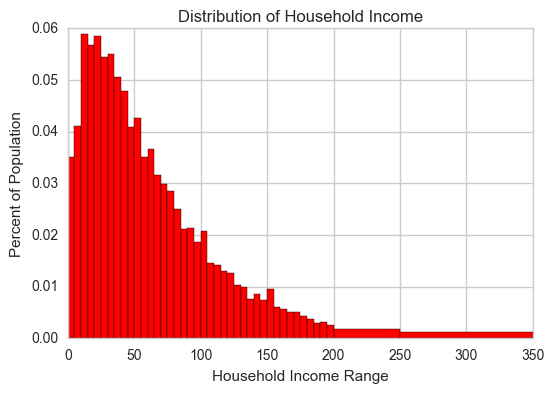

In [4]:
fig, ax = plt.subplots()
rects1 = ax.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
ax.set_ylabel('Percent of Population')
ax.set_xlabel('Household Income Range')
ax.set_title('Distribution of Household Income')


# Part B

## GMM to fit lognormal dist

We want to estimate the mean and variance parameters to match the moments of the data to the predicted lognormal distribution.

In [5]:
import scipy.stats as sts

def errors_lognorm(params, *args):
    # Function to return a 42x1 vector of errors
    mu, sigma = params
    pdf_vals, bottom_points,top_points = args
    bottom_points[0] = 0.5 # just make evaluable by log()
    lower_cdfval = sts.lognorm.cdf(list(bottom_points),scale=np.exp(mu),s=sigma)
    upper_cdfval = sts.lognorm.cdf(list(top_points),scale=np.exp(mu),s=sigma)
    lower_cdfval[0]=0
    upper_cdfval[41]=1
    prob_int = upper_cdfval - lower_cdfval # difference the CDFs to find out interval probability
    error_vec = (pdf_vals - prob_int)/pdf_vals
    return np.array(error_vec)

def crit_lognorm(params, *args):
    mu, sigma = params
    pdf_vals, bottom_points, top_points, W = args
    errors = errors_lognorm([mu,sigma],pdf_vals, bottom_points,top_points)
    objective = np.dot(np.dot(errors.T, W), errors) 
    return objective

In [6]:
crit_lognorm([50,1000],df['Percent'],df['bottom'],df['top'],np.eye(42))

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


651.85141100042006

In [7]:
# optimizing
import scipy.optimize as opt
gmm_init = [11,10] # initial values
W_init = np.multiply(df['Percent'].values,np.eye(42))
gmm_args = (df['Percent'],df['bottom'],df['top'],W_init)
results = opt.minimize(crit_lognorm, gmm_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('mu_GMM1=', 10.766843775113065, ' sig_GMM1=', 0.90784128695645905)


In [8]:
results

      fun: 0.045945282528426598
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.28743715e-07,   1.06858966e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 12
   status: 0
  success: True
        x: array([ 10.76684378,   0.90784129])

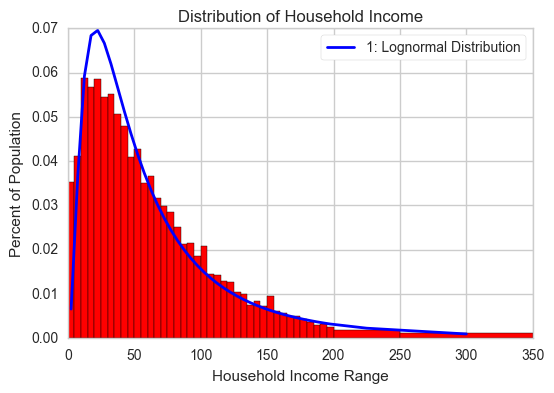

In [9]:
dist_pts = list(df['Midpoint']/1000)
fitted_vals = sts.lognorm.cdf(list(df['top']), scale=np.exp(mu_GMM1), s=sig_GMM1)-sts.lognorm.cdf(list(df['bottom']),scale=np.exp(mu_GMM1),s=sig_GMM1)
fitted_vals[41] = fitted_vals[41]/20
fitted_vals[40] = fitted_vals[40]/10
#plot
plt.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
plt.plot(dist_pts, fitted_vals,
         linewidth=2, color='b',label='1: Lognormal Distribution')
plt.ylabel('Percent of Population')
plt.xlabel('Household Income Range')
plt.title('Distribution of Household Income')
plt.legend(loc='upper right',frameon=True,fancybox=True)

# Part C

## Fit Gamma Dist via GMM

We are going to fit the Gamma 2-parameter distribution to the data using GMM.

Starting values are $\alpha_0=3$ and $\beta_0=20000$

We will use the same weighting matrix.

In [10]:
def errors_gamma(params,*args):
    alpha, beta = params
    pdf_vals, bottom_points,top_points = args
    bottom_points[0] = 0.5 # just make evaluable by our formula
    lower_cdfval = sts.gamma.cdf(list(bottom_points),alpha,loc=0,scale=beta)
    upper_cdfval = sts.gamma.cdf(list(top_points),alpha,loc=0,scale=beta)
    lower_cdfval[0]=0
    upper_cdfval[41]=1
    prob_int = upper_cdfval - lower_cdfval # difference the CDFs to find out interval probability
    error_vec = (pdf_vals - prob_int)/pdf_vals
    return np.array(error_vec)

def crit_gamma(params,*args):
    alpha,beta = params
    pdf_vals, bottom_points, top_points, W = args
    errors = errors_gamma([alpha,beta],pdf_vals, bottom_points,top_points)
    objective = np.dot(np.dot(errors.T, W), errors) 
    return objective

In [11]:
import scipy.optimize as opt
gmm_gamma_init = [3,20000] # initial values
W_init = np.multiply(df['Percent'].values,np.eye(42))
gmm_args = (df['Percent'],df['bottom'],df['top'],W_init)
results_gamma = opt.minimize(crit_gamma, gmm_gamma_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM1, beta_GMM1 = results_gamma.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=',beta_GMM1)

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('alpha_GMM1=', 1.3616762786240897, ' beta_GMM1=', 48370.938028645847)


In [12]:
results_gamma

      fun: 0.012343057380640603
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.26356866e-05,  -2.49800181e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 29
   status: 0
  success: True
        x: array([  1.36167628e+00,   4.83709380e+04])

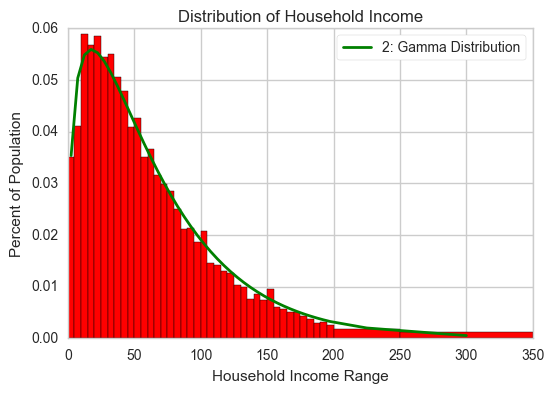

In [13]:
#plot
dist_pts = list(df['Midpoint']/1000)
fitted_vals_gamma = sts.gamma.cdf(list(df['top']),alpha_GMM1,loc=0,scale=beta_GMM1)-sts.gamma.cdf(list(df['bottom']),alpha_GMM1,loc=0,scale=beta_GMM1)
fitted_vals_gamma[41] = fitted_vals_gamma[41]/20
fitted_vals_gamma[40] = fitted_vals_gamma[40]/10
#plot
plt.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
plt.plot(dist_pts, fitted_vals_gamma,
         linewidth=2, color='g',label='2: Gamma Distribution')
plt.ylabel('Percent of Population')
plt.xlabel('Household Income Range')
plt.title('Distribution of Household Income')
plt.legend(loc='upper right',frameon=True,fancybox=True)

# Part D

We are going to plot both distributions together:

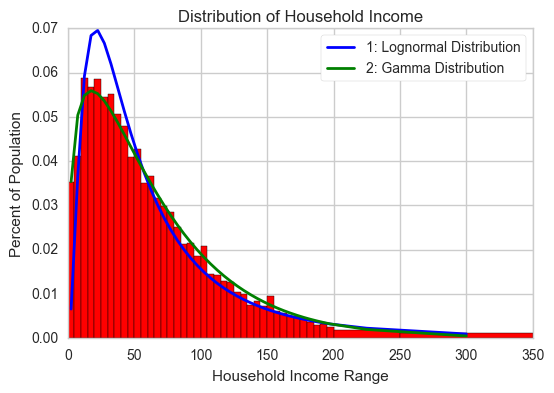

In [14]:
#plot
dist_pts = list(df['Midpoint']/1000)
fitted_vals = sts.lognorm.cdf(list(df['top']), scale=np.exp(mu_GMM1), s=sig_GMM1)-sts.lognorm.cdf(list(df['bottom']),scale=np.exp(mu_GMM1),s=sig_GMM1)
fitted_vals[41] = fitted_vals[41]/20
fitted_vals[40] = fitted_vals[40]/10
fitted_vals_gamma = sts.gamma.cdf(list(df['top']),alpha_GMM1,loc=0,scale=beta_GMM1)-sts.gamma.cdf(list(df['bottom']),alpha_GMM1,loc=0,scale=beta_GMM1)
fitted_vals_gamma[41] = fitted_vals_gamma[41]/20
fitted_vals_gamma[40] = fitted_vals_gamma[40]/10
#plot
plt.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
plt.plot(dist_pts, fitted_vals,
         linewidth=2, color='b',label='1: Lognormal Distribution')
plt.plot(dist_pts, fitted_vals_gamma,
         linewidth=2, color='g',label='2: Gamma Distribution')
plt.ylabel('Percent of Population')
plt.xlabel('Household Income Range')
plt.title('Distribution of Household Income')
plt.legend(loc='upper right',frameon=True,fancybox=True)
plt.savefig('Income_Dist.png',dpi=500)

## Comparing the 2 estimators

Since we are using the same weighting matrix, one measure we could use to compare is the objective function value at the fitted values.

For LN, this is 0.045945282528426598

For GA, this is 0.012343057380640603

This suggests that the Gamma is a better fit for this data. 

# Part E

We want to now compute the 2-step weighting matrix for the Gamma and re-estimate

We can take the parameter estimates, and then we can compute $$ \hat{\Omega}_2 = \frac{1}{N}e(x|\hat{\theta}_{1,GMM})\,e(x|\hat{\theta}_{1,GMM})^T $$

The inverse of this will be our new weighting matrix, and then we can re-optimize. 

In [15]:
fitted_errors=errors_gamma(results_gamma.x,df['Percent'],df['bottom'],df['top'])
vcv_gamma1= (len(fitted_errors)**-1)*np.outer(fitted_errors, fitted_errors.T)
W_2step = np.linalg.pinv(vcv_gamma1)

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
import scipy.optimize as opt
gmm_gamma_init_2 = results_gamma.x # initial values are old fitted values
gmm_args2 = (df['Percent'],df['bottom'],df['top'],W_2step)
results_gamma_2step = opt.minimize(crit_gamma, gmm_gamma_init, args=(gmm_args2), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM2, beta_GMM2 = results_gamma_2step.x
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=',beta_GMM2)

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('alpha_GMM2=', 3.3435521791279803, ' beta_GMM2=', 20000.000068427449)


In [17]:
results_gamma_2step

      fun: -5.4068340455195473e-16
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.15328350e-06,  -4.08143051e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([  3.34355218e+00,   2.00000001e+04])

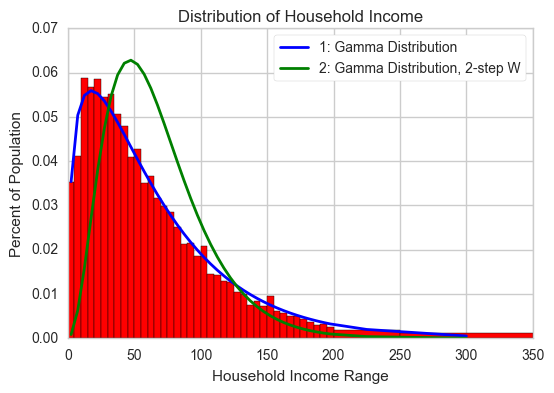

In [18]:
# plot
dist_pts = list(df['Midpoint']/1000)
fitted_vals = sts.gamma.cdf(list(df['top']),alpha_GMM1,loc=0,scale=beta_GMM1)-sts.gamma.cdf(list(df['bottom']),alpha_GMM1,loc=0,scale=beta_GMM1)
fitted_vals[41] = fitted_vals[41]/20
fitted_vals[40] = fitted_vals[40]/10
fitted_vals_gamma = sts.gamma.cdf(list(df['top']),alpha_GMM2,loc=0,scale=beta_GMM2)-sts.gamma.cdf(list(df['bottom']),alpha_GMM2,loc=0,scale=beta_GMM2)
fitted_vals_gamma[41] = fitted_vals_gamma[41]/20
fitted_vals_gamma[40] = fitted_vals_gamma[40]/10
#plot
plt.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
plt.plot(dist_pts, fitted_vals,
         linewidth=2, color='b',label='1: Gamma Distribution')
plt.plot(dist_pts, fitted_vals_gamma,
         linewidth=2, color='g',label='2: Gamma Distribution, 2-step W')
plt.ylabel('Percent of Population')
plt.xlabel('Household Income Range')
plt.title('Distribution of Household Income')
plt.legend(loc='upper right',frameon=True,fancybox=True)